# PyCAS Tutorial
Welcome to the PyCAS Crash Course! Use SHIFT+ENTER to jump through the Notebook.
## Why PyCAS?
We wanted to make working with PyPropagate as easy as possible - even for inexperienced programmers - without loosing performance to inefficiently written python scripts. The solution was to use a symbolic library to define all simulation parameters. These are then optimized and compiled to low-level code on the fly. There is only one well-known symbolic library for python: `sympy`.

In [1]:
import sympy as sp

However, working with `sympy` turned out to be quite complicated and soon some serious issues arose. For example, lets try to define a material with the complex refractive index $1+10^{-14}\;i$ in `sympy`:

In [2]:
index_of_refraction = sp.S(1 + 10**-14 * 1j)
index_of_refraction.simplify()

1.00000000000000

Yikes! It completely forgot about the imaginary part (at least in the current stable release: 0.7.6.1). As it turns out, this and other bugs make using `sympy` for serious tasks quite risky. Unfortunately, there are no known alternatives for python, so we had to write our own: the symbolic library `Expresso` and minimal computer algebra system `PyCAS` were born!

In [3]:
import expresso.pycas as pc

In [4]:
index_of_refraction = pc.S(1 + 10**-14 * 1j)
index_of_refraction.evaluate()

1+i/1e14

## Working with symbols
We can define a `PyCAS` symbol using the `pc.Symbol` function. To define multiple symbols at once we can use `pc.symbols` with a comma-separated string.  

In [5]:
wavelength = pc.Symbol('lambda') # wavelength because lambda is a reserved keyword in python
x,y,z = pc.symbols('x,y,z')

We can create expressions by using some built-in python operators such as `+-*/` or by using predefined functions in `PyCAS`. 

In [6]:
pc.sqrt( pc.sin(x) + z / (wavelength + y) )

sqrt(sin(x)+z/(lambda+y))

We can also use numbers in our expressions, which will automatically be converted to PyCAS symbols. Be aware that operations on numbers will still first be evaluated in python before they are used in a `PyCAS` function. To explicitly convert a number to `PyCAS` we can use the `pc.S` function.

In [7]:
x - z * 2 / 3

x-z/3*2

In [8]:
x + 2 / 3 # Here the expression 1/3 is first evaluated by python (and integer division yields 0)

0+x

In [9]:
x + pc.S(2) / 3 # The whole expression is converted to PyCAS

1/3*2+x

### Exercises:
1. What happens when you try to convert a floating point number to an expression? Set the variable `n` below to different integer values (e.g. 1,2,3) and see what happens. 
2. Can you explain this behavior?
3. Change the second line to preserve the exact representation of the number.

In [ ]:
n = ### <- insert integer here
pc.S(1./n)

## Manipulating expressions
`PyCAS` can evaluate and simplify expressions to some extent using the `expression.evalute()` method. Note that its power is still somewhat limited.

In [10]:
expr = ((-2*x**(z)*(y+2*y/6)/x**(z-1)-y*(x+x/3)+42*3*x**2/(3*x*y**((x-2*x)/x)))+4*x*y)/(x*y)
expr

(1/(x*3*y**(1/x*(x-x*2)))*126*x**2+1/x**(z-1)*(y+y*2/6)*x**z*(-2)+x*4*y-(x+x/3)*y)/(x*y)

In [11]:
expr.evaluate()

42

In [12]:
expr = pc.derivative(pc.exp(x*y)*x**2,x)
expr.evaluate()

exp(x*y)*(x*2+y*x**2)

To access the arguments of a function we can use the `expression.args` member of an expression. For commuatative functions the arguments are not necessarily in the same order as in the definition or when its printed. To get the callable function itself we can use the `expression.function` member.

In [13]:
expr.evaluate().args

[exp(x*y), x*2+y*x**2]

In [14]:
expr.evaluate().args[1].function(x,y)

x+y

It is possible to define your own functions using the `pc.Function` class.

In [15]:
f = pc.Function('f')
f(x**2+y)

f(x**2+y)

Values inside expressions can be substituted using the `expression.subs` method. It is possible to perform multiple substitutions at once.

In [16]:
(x*y**2+y*wavelength).subs(y,wavelength).evaluate()

lambda**2*(1+x)

In [17]:
(x*(x+y)).subs([(x,y),(y,x)])

(x+y)*y

### Exercises:
1. Define $a$ and $b$ as symbols in the cell below to create a piecewise defined function.
2. Change the substitution in two cells below so the result is $a$.
3. Can you chain the `expression.args` method multiple times to extract the $x>0$ condition from `piecewise_defined_function`? Note that in the special case of `piecewise` there is a hidden outer function.
4. Can a piecewise function contain more than two cases?
5. What happens when the derivative of a function is unknown? Define a function $g$ and calculate $\partial_x \; f(g(x))$ and $\partial_x \; f(x)\cdot g(x) $.

In [ ]:
a,b = ### <- define symbols here
piecewise_defined_function = pc.piecewise((a,x>0),(b,True))
piecewise_defined_function

In [ ]:
piecewise_defined_function.subs(x,0).evaluate()

In [ ]:
piecewise_defined_function.args[0]

## Numerical evaluation and compilation
If an expression contains only numerical symbols and standard functions (functions which are defined in the python `mpmath` module) it can be evaluated numerically to an arbitrary precision. This is done with the `expression.N(precision)` function. 

In [18]:
(pc.sqrt(2)).N(100)

mpf('1.414213562373095048801688724209698078569671875376948073176679737990732478462107038850387534327641572735')

In [19]:
(4*pc.atan(1)).N(1000) # accurate to the first 1000 digits of pi

mpf('3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724587006606315588174881520920962829254091715364367892590360011330530548820466521384146951941511609433057270365759591953092186117381932611793105118548074462379962749567351885752724891227938183011949129833673362440656643086021394946395224737190702179860943702770539217176293176752384674818467669405132000568127145263560827785771342757789609173637178721468440901224953430146549585371050792279689258923542019956112129021960864034418159813629774771309960518707211349999998372978049951059731732816096318595024459455346908302642522308253344685035261931188171010003137838752886587533208381420617177669147303598253490428755468731159562863882353787593751957781857780532171226806613001927876611195909216

Expressions that contain symbols can be compiled to numpy (or c) functions that can operate on huge arrays very efficiently. The compiled function will be applied element-wise on the arrays. If the return value of the function cannot be deduced, the function result is casted to `complex` (this can be overwritten by defining the `restype` argument of `pc.numpyfy`). The compiled functions take the name of the symbols contained in the expression as keyword arguments.

In [20]:
# import numpy and a pllotting library
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [21]:
func = pc.piecewise((pc.sin(2*x)**5,(pc.sin(x)>0) ),(pc.sin(4*x)**2,True))
func

piecewise(tuple(sin(x*2)**5,sin(x)>0),tuple(sin(x*4)**2,True))

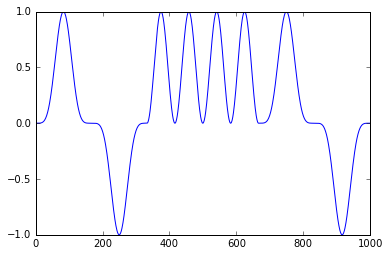

In [22]:
numpy_function = pc.numpyfy(func)
plt.plot(numpy_function(x = np.linspace(0,3*np.pi,1000)).real)

In [23]:
func = pc.sin(x)*pc.sin(y)
func

sin(x)*sin(y)

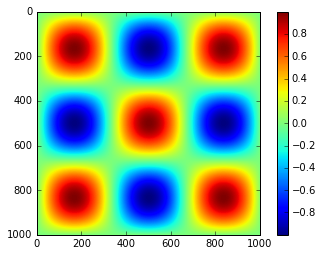

In [24]:
numpy_function = pc.numpyfy(func,restype=float)
ny,nx = np.meshgrid(np.linspace(0,3*np.pi,1000),np.linspace(0,3*np.pi,1000))
plt.imshow(numpy_function(x = nx,y = ny))
plt.colorbar()

### Exercises:
1. Using the logical and function (`pc.And`) define a expression describing the refractive index of a square Waveguide (arbitrary size and material).
2. Plot the waveguide using `plt.imshow`.

## Array Access Operations
We can embed numpy arrays in our expressions using the `pc.array(name,array)` function definition. This will become useful in case an expression is too complicated or computationally intensive to be evaluated explicitly in the expression. Arra access operations are created by calling the array function just lika an ordinary function. If the argument is less than 0 or larger or equal ot the size of the array, the array access returns 0.

In [25]:
rand = pc.array('rand',np.random.rand(100))
rand(x*100)

rand[ 1e2*x \right]

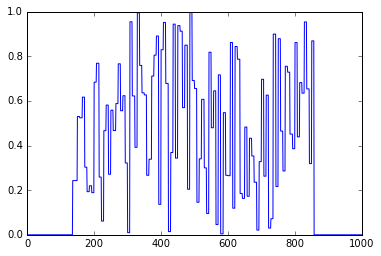

In [26]:
plt.plot(pc.numpyfy(rand(x*10),restype=float)(x=np.linspace(-2,12,1000)))

### Exercises:
1. How could you define the refractive index $n(x,y)$ of [circular zoneplate](https://en.wikipedia.org/wiki/Zone_plate)?
2. How could you define the refractive index of a zoneplate with arbitrary zone distances using an array access operation? 
3. **Bonus Points:** using the function below and an array access operation, define and plot the refractive index for a binary zoneplate with 100 zones.

In [ ]:
def zone_radius(i,wavelength = 1,F = 1):
    return (i*wavelength*F + i**2*wavelength**2/4)**0.5

i = pc.Symbol('i')
zone_radius(i).evaluate()